# 1.0 References

- https://hmmlearn.readthedocs.io/en/latest/
- https://medium.com/@natsunoyuki/hidden-markov-models-with-python-c026f778dfa7
- https://www.tutorialspoint.com/artificial_intelligence_with_python/artificial_intelligence_with_python_analyzing_time_series_data.htm
- https://github.com/PacktPublishing/Artificial-Intelligence-with-Python/blob/master/Chapter%2011/code/hmm.py
- https://unit8co.github.io/darts/README.html
- https://medium.com/unit8-machine-learning-publication/training-forecasting-models-on-multiple-time-series-with-darts-dc4be70b1844
- https://unit8co.github.io/darts/examples.html
- https://www.machinelearningplus.com/time-series/time-series-analysis-python/
- https://facebook.github.io/prophet/
- https://www.phdata.io/blog/facebook-prophet-tutorial-time-series-forecasting/

# 2.0 Setup notebook

## 2.1 Reset notebook

In [93]:
%reset -f

## 2.2 Setup notebook to full width

In [94]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [95]:
# Dataframe display setting
import pandas as pd
pd.set_option('display.max_columns', None)

## 2.3 Align table to left side

In [96]:
%%html
<style>
    table {float:left}
</style>

## 2.4 Get current working directory

In [97]:
import os
print('Current working directory : ', os.getcwd())

Current working directory :  /home/jupyter/drought_prediction/05_Modeling


# 3.0 Install required libraries

In [98]:
#!pip install hmmlearn
#!pip install git+https://github.com/deeptime-ml/deeptime.git@main
#!pip install pyemma
#!pip install IOHMM
#!pip install darts
#!pip install matplotlib
#!pip install prophet
#!pip uninstall prophet && pip install prophet==1.1.1

# 4.0 Import required libraries

In [99]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing

from datetime import datetime

from dateutil.parser import parse

import hmmlearn as hmm
from hmmlearn import hmm
from hmmlearn.hmm import GMMHMM
from hmmlearn.hmm import GaussianHMM
from hmmlearn.hmm import MultinomialHMM

import math

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

import pickle

import plotly.graph_objs as go
import plotly.offline as pyo

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.serialize import model_to_json, model_from_json

from scipy.spatial.distance import cdist 

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

import time

import warnings
warnings.filterwarnings('ignore')

# Open the plot in a web browser
import webbrowser

# 5.0 Load data

In [100]:
# Load the time series data from a CSV file or create a pandas DataFrame
data1 = pd.read_csv('/home/jupyter/drought_prediction/00_data/clean_data/3_PostEDA2.csv')
#data1 = pd.read_csv('/home/jupyter/drought_prediction/00_data/clean_data/3_PostEDA.csv')

# 6.0 Basic statistics on data loaded

In [101]:
data1.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756796 entries, 0 to 2756795
Data columns (total 57 columns):
 #   Column         Dtype  
---  ------         -----  
 0   lat            float64
 1   FOR_LAND       float64
 2   T2MWET         float64
 3   date           object 
 4   SQ2            int64  
 5   score          float64
 6   slope3         float64
 7   day_of_week    int64  
 8   aspectN        float64
 9   slope8         float64
 10  SQ6            int64  
 11  SQ3            int64  
 12  day_of_month   int64  
 13  fips           int64  
 14  SQ1            int64  
 15  T2MDEW         float64
 16  T2M            float64
 17  T2M_RANGE      float64
 18  WS10M_RANGE    float64
 19  CULTIR_LAND    float64
 20  URB_LAND       float64
 21  CULT_LAND      float64
 22  elevation      int64  
 23  WS50M_MAX      float64
 24  PS             float64
 25  month          int64  
 26  WS50M          float64
 27  WS50M_MIN      float64
 28  slope2         float64
 29  aspectS       

In [102]:
data1.head(10)

,lat,FOR_LAND,T2MWET,date,SQ2,score,slope3,day_of_week,aspectN,slope8,SQ6,SQ3,day_of_month,fips,SQ1,T2MDEW,T2M,T2M_RANGE,WS10M_RANGE,CULTIR_LAND,URB_LAND,CULT_LAND,elevation,WS50M_MAX,PS,month,WS50M,WS50M_MIN,slope2,aspectS,slope7,aspectUnknown,CULTRF_LAND,GRS_LAND,WS50M_RANGE,T2M_MAX,WS10M,NVG_LAND,slope5,year,T2M_MIN,TS,slope6,slope4,aspectW,QV2M,WAT_LAND,WS10M_MAX,SQ7,WS10M_MIN,PRECTOT,slope1,SQ5,SQ4,lon,aspectE,state
0,32.536382,10.714703,6.10,2000-01-04,1,1.0,0.2984,1,0.1033,0.0,1,1,4,1001,1,6.09,11.40,15.92,3.59,1.014811,0.2889,57.308224,63,9.31,100.29,1,6.73,3.74,0.2788,0.2003,0.0,0.3207,56.293411,2.750274,5.58,18.09,3.84,27.940498,0.1142,2000,2.16,11.31,0.017,0.2497,0.1898,6.42,0.9974,5.67,2,2.08,15.95,0.0419,1,1,-86.64449,0.1859,Alabama
1,32.536382,10.714703,7.84,2000-01-11,1,2.0,0.2984,1,0.1033,0.0,1,1,11,1001,1,7.84,11.48,13.16,1.43,1.014811,0.2889,57.308224,63,6.38,100.40,1,3.55,1.71,0.2788,0.2003,0.0,0.3207,56.293411,2.750274,4.67,18.88,1.76,27.940498,0.1142,2000,5.72,10.43,0.017,0.2497,0.1898,6.63,0.9974,2.48,2,1.05,1.33,0.0419,1,1,-86.64449,0.1859,Alabama
2,32.536382,10.714703,13.26,2000-01-18,1,2.0,0.2984,1,0.1033,0.0,1,1,18,1001,1,13.26,14.28,9.06,1.92,1.014811,0.2889,57.308224,63,6.40,100.39,1,5.19,3.84,0.2788,0.2003,0.0,0.3207,56.293411,2.750274,2.55,18.04,2.63,27.940498,0.1142,2000,8.98,14.19,0.017,0.2497,0.1898,9.53,0.9974,3.60,2,1.67,1.11,0.0419,1,1,-86.64449,0.1859,Alabama
3,32.536382,10.714703,-7.72,2000-01-25,1,2.0,0.2984,1,0.1033,0.0,1,1,25,1001,1,-7.93,-0.78,11.11,2.32,1.014811,0.2889,57.308224,63,8.03,100.11,1,5.75,3.96,0.2788,0.2003,0.0,0.3207,56.293411,2.750274,4.07,5.65,3.35,27.940498,0.1142,2000,-5.46,-0.61,0.017,0.2497,0.1898,2.05,0.9974,4.59,2,2.28,0.00,0.0419,1,1,-86.64449,0.1859,Alabama
4,32.536382,10.714703,-1.70,2000-02-01,1,1.0,0.2984,1,0.1033,0.0,1,1,1,1001,1,-1.73,2.06,15.23,1.86,1.014811,0.2889,57.308224,63,6.38,101.00,2,4.18,1.27,0.2788,0.2003,0.0,0.3207,56.293411,2.750274,5.11,11.02,2.03,27.940498,0.1142,2000,-4.21,1.88,0.017,0.2497,0.1898,3.36,0.9974,2.74,2,0.88,0.00,0.0419,1,1,-86.64449,0.1859,Alabama
5,32.536382,10.714703,3.91,2000-02-08,1,1.0,0.2984,1,0.1033,0.0,1,1,8,1001,1,3.90,8.88,14.99,1.55,1.014811,0.2889,57.308224,63,5.33,101.04,2,2.74,0.69,0.2788,0.2003,0.0,0.3207,56.293411,2.750274,4.63,17.64,1.30,27.940498,0.1142,2000,2.65,8.31,0.017,0.2497,0.1898,5.01,0.9974,2.04,2,0.48,0.00,0.0419,1,1,-86.64449,0.1859,Alabama
6,32.536382,10.714703,5.84,2000-02-15,1,1.0,0.2984,1,0.1033,0.0,1,1,15,1001,1,5.84,10.94,18.52,0.96,1.014811,0.2889,57.308224,63,7.63,100.68,2,4.62,2.57,0.2788,0.2003,0.0,0.3207,56.293411,2.750274,5.07,20.57,2.09,27.940498,0.1142,2000,2.05,10.96,0.017,0.2497,0.1898,5.84,0.9974,2.69,2,1.73,0.00,0.0419,1,1,-86.64449,0.1859,Alabama
7,32.536382,10.714703,4.00,2000-02-22,1,1.0,0.2984,1,0.1033,0.0,1,1,22,1001,1,3.99,10.02,16.08,1.07,1.014811,0.2889,57.308224,63,7.13,101.34,2,4.96,2.67,0.2788,0.2003,0.0,0.3207,56.293411,2.750274,4.46,18.57,2.30,27.940498,0.1142,2000,2.49,10.07,0.017,0.2497,0.1898,5.03,0.9974,2.84,2,1.77,0.36,0.0419,1,1,-86.64449,0.1859,Alabama
8,32.536382,10.714703,7.49,2000-02-29,1,1.0,0.2984,1,0.1033,0.0,1,1,29,1001,1,7.49,12.61,17.25,1.45,1.014811,0.2889,57.308224,63,7.64,100.71,2,5.09,2.10,0.2788,0.2003,0.0,0.3207,56.293411,2.750274,5.54,21.52,2.30,27.940498,0.1142,2000,4.27,12.61,0.017,0.2497,0.1898,6.52,0.9974,2.90,2,1.45,0.01,0.0419,1,1,-86.64449,0.1859,Alabama
9,32.536382,10.714703,9.47,2000-03-07,1,1.0,0.2984,1,0.1033,0.0,1,1,7,1001,1,9.47,16.81,15.27,1.06,1.014811,0.2889,57.308224,63,6.92,100.79,3,3.96,1.84,0.2788,0.2003,0.0,0.3207,56.293411,2.750274,5.07,25.15,2.03,27.940498,0.1142,2000,9.89,15.49,0.017,0.2497,0.1898,7.48,0.9974,2.51,2,1.45,0.00,0.0419,1,1,-86.64449,0.1859,Alabama


In [103]:
data1.describe()

,lat,FOR_LAND,T2MWET,SQ2,score,slope3,day_of_week,aspectN,slope8,SQ6,SQ3,day_of_month,fips,SQ1,T2MDEW,T2M,T2M_RANGE,WS10M_RANGE,CULTIR_LAND,URB_LAND,CULT_LAND,elevation,WS50M_MAX,PS,month,WS50M,WS50M_MIN,slope2,aspectS,slope7,aspectUnknown,CULTRF_LAND,GRS_LAND,WS50M_RANGE,T2M_MAX,WS10M,NVG_LAND,slope5,year,T2M_MIN,TS,slope6,slope4,aspectW,QV2M,WAT_LAND,WS10M_MAX,SQ7,WS10M_MIN,PRECTOT,slope1,SQ5,SQ4,lon,aspectE
count,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2756796.0,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06,2.756796e+06
mean,3.827826e+01,3.930923e+01,7.084938e+00,1.553732e+00,8.245298e-01,3.198956e-01,1.0,1.437460e-01,9.269949e-03,1.135135e+00,1.281853e+00,1.568997e+01,3.067038e+04,1.830759e+00,7.049350e+00,1.289923e+01,1.124720e+01,3.282268e+00,3.505807e+00,2.670885e+00,3.200978e+01,4.273517e+02,7.828799e+00,9.664736e+01,6.520857e+00,5.532799e+00,3.121578e+00,2.977828e-01,1.483784e-01,2.223012e-02,3.527689e-01,2.850397e+01,1.978932e+01,4.707223e+00,1.876711e+01,3.564075e+00,1.799070e+00,5.342471e-02,2.007999e+03,7.519916e+00,1.297493e+01,6.534376e-02,1.558736e-01,1.650558e-01,7.875770e+00,2.851428e+00,5.202917e+00,1.284749e+00,1.920655e+00,2.714566e+00,5.498610e-02,1.147040e+00,1.357465e+00,-9.165564e+01,1.688575e-01
std,4.837604e+00,3.435830e+01,1.014364e+01,1.021334e+00,1.223727e+00,1.676431e-01,0.0,7.823664e-02,4.493247e-02,9.144986e-01,1.002426e+00,8.798878e+00,1.497911e+04,1.192126e+00,1.019765e+01,1.097040e+01,4.038022e+00,1.943136e+00,1.029070e+01,9.770578e+00,3.309469e+01,4.999273e+02,2.836618e+00,5.444698e+00,3.447033e+00,2.298550e+00,2.109945e+00,2.159424e-01,8.210785e-02,6.412598e-02,2.721707e-01,3.183540e+01,2.541556e+01,2.181020e+00,1.160295e+01,1.847645e+00,7.970701e+00,7.310133e-02,4.897714e+00,1.061818e+01,1.119095e+01,1.255203e-01,1.283995e-01,8.784228e-02,4.721459e+00,1.315915e+01,2.609219e+00,1.017384e+00,1.342458e+00,6.247590e+00,8.986990e-02,9.223040e-01,1.030091e+00,1.148296e+01,8.408805e-02
min,2.560104e+01,0.000000e+00,-3.546000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.001000e+03,0.000000e+00,-3.544000e+01,-3.544000e+01,1.600000e-01,2.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,8.500000e-01,6.649000e+01,1.000000e+00,5.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.200000e-01,-3.003000e+01,2.900000e-01,0.000000e+00,0.000000e+00,2.000000e+03,-4.085000e+01,-3.716000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.400000e-01,0.000000e+00,5.700000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.242114e+02,0.000000e+00
25%,3.468499e+01,4.575617e+00,-8.400000e-01,1.000000e+00,0.000000e+00,1.857750e-01,1.0,8.617500e-02,0.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00,1.904450e+04,1.000000e+00,-8.800000e-01,4.580000e+00,8.370000e+00,1.820000e+00,4.598666e-02,1.048276e-01,1.612849e+00,1.320000e+02,5.700000e+00,9.583000e+01,4.000000e+00,3.820000e+00,1.450000e+00,1.048500e-01,8.627500e-02,0.000000e+00,1.156000e-01,1.539787e-01,4.359078e+00,3.140000e+00,1.036000e+01,2.140000e+00,0.000000e+00,5.000000e-04,2.004000e+03,-5.700000e-01,4.460000e+00,0.000000e+00,4.072500e-02,1.015000e-01,3.810000e+00,0.000000e+00,3.130000e+00,1.000000e+00,9.600000e-01,0.000000e+00,8.300000e-03,1.000000e+00,1.000000e+00,-9.803500e+01,1.092000e-01
50%,3.832501e+

# 7.0 Data Preprocessing

In [104]:
df_copy = data1.copy(deep=True)

## 7.1 Set variables

In [105]:
Chosen_FIPS = 21073
    #1001 - High drought values; > 3 | stationary data
    #1003 - Low drought values; 1 < n < 3 | stationary data
    #6079 - Very high drought values; > 4.8 and constant | non-stationary data
    #8093 - 1.5 constant | non-stationary data
    #21073 - sd; 1 - mostly 3 | stationary data
    #24510 - sd; all 2 | stationary data
    #24045 - No drought values; = 0 | stationary data
no_of_periods_of_prediction = 46 #46 
epsilon = 0 #1e-10  # a small positive number, used in cases where we want to avoid infinity in our statistical calculations
result = []
regResult = pd.DataFrame(columns=['model_name', 'y_true', 'y_pred', 'mse', 'mae', 'rmse', 'mape', 'smape', 'r_squared', 'forecast_acc'])

## 7.2 Create dataset for the chosen FIPS

In [106]:
data = data1[data1['fips'] == Chosen_FIPS].reset_index(drop=True)

In [107]:
#Check the data subset loaded
data.head(10)

,lat,FOR_LAND,T2MWET,date,SQ2,score,slope3,day_of_week,aspectN,slope8,SQ6,SQ3,day_of_month,fips,SQ1,T2MDEW,T2M,T2M_RANGE,WS10M_RANGE,CULTIR_LAND,URB_LAND,CULT_LAND,elevation,WS50M_MAX,PS,month,WS50M,WS50M_MIN,slope2,aspectS,slope7,aspectUnknown,CULTRF_LAND,GRS_LAND,WS50M_RANGE,T2M_MAX,WS10M,NVG_LAND,slope5,year,T2M_MIN,TS,slope6,slope4,aspectW,QV2M,WAT_LAND,WS10M_MAX,SQ7,WS10M_MIN,PRECTOT,slope1,SQ5,SQ4,lon,aspectE,state
0,38.234919,16.369389,0.14,2000-01-04,1,2.0000,0.4931,1,0.2042,0.0001,1,1,4,21073,1,0.11,3.43,16.74,1.78,1.963493,0.7735,80.471748,238,8.92,98.46,1,7.78,6.49,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,2.43,13.49,5.30,0.0,0.0458,2000,-3.25,3.42,0.0288,0.2395,0.2227,4.20,0.0,5.94,1,4.16,4.64,0.0127,1,1,-84.868786,0.213,Kentucky
1,38.234919,16.369389,-2.10,2000-01-11,1,1.1583,0.4931,1,0.2042,0.0001,1,1,11,21073,1,-2.16,3.41,8.99,6.67,1.963493,0.7735,80.471748,238,12.31,98.50,1,8.69,2.83,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,9.48,7.51,5.19,0.0,0.0458,2000,-1.48,2.89,0.0288,0.2395,0.2227,3.34,0.0,8.48,1,1.81,0.03,0.0127,1,1,-84.868786,0.213,Kentucky
2,38.234919,16.369389,-3.48,2000-01-18,1,1.1583,0.4931,1,0.2042,0.0001,1,1,18,21073,1,-3.51,-1.50,4.67,2.76,1.963493,0.7735,80.471748,238,5.67,98.92,1,4.25,1.47,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,4.20,1.36,2.88,0.0,0.0458,2000,-3.31,-1.25,0.0288,0.2395,0.2227,2.96,0.0,3.88,1,1.12,0.98,0.0127,1,1,-84.868786,0.213,Kentucky
3,38.234919,16.369389,-10.11,2000-01-25,1,1.0000,0.4931,1,0.2042,0.0001,1,1,25,21073,1,-10.20,-7.88,9.41,5.23,1.963493,0.7735,80.471748,238,7.68,98.45,1,4.78,0.60,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,7.08,-3.37,3.35,0.0,0.0458,2000,-12.78,-8.13,0.0288,0.2395,0.2227,1.72,0.0,5.63,1,0.40,0.32,0.0127,1,1,-84.868786,0.213,Kentucky
4,38.234919,16.369389,-5.65,2000-02-01,1,1.0071,0.4931,1,0.2042,0.0001,1,1,1,21073,1,-5.68,-3.69,7.28,2.39,1.963493,0.7735,80.471748,238,7.67,99.24,2,6.35,5.11,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,2.56,0.11,3.78,0.0,0.0458,2000,-7.17,-3.94,0.0288,0.2395,0.2227,2.48,0.0,5.11,1,2.72,0.14,0.0127,1,1,-84.868786,0.213,Kentucky
5,38.234919,16.369389,-2.01,2000-02-08,1,1.1064,0.4931,1,0.2042,0.0001,1,1,8,21073,1,-2.03,1.27,11.19,2.22,1.963493,0.7735,80.471748,238,5.53,99.78,2,2.91,0.70,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,4.83,7.87,1.84,0.0,0.0458,2000,-3.32,0.08,0.0288,0.2395,0.2227,3.29,0.0,2.71,1,0.50,0.00,0.0127,1,1,-84.868786,0.213,Kentucky
6,38.234919,16.369389,-0.98,2000-02-15,1,1.1064,0.4931,1,0.2042,0.0001,1,1,15,21073,1,-1.00,2.76,12.61,6.92,1.963493,0.7735,80.471748,238,13.03,99.06,2,5.12,0.09,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,12.94,8.44,2.94,0.0,0.0458,2000,-4.17,2.34,0.0288,0.2395,0.2227,3.63,0.0,6.99,1,0.07,0.11,0.0127,1,1,-84.868786,0.213,Kentucky
7,38.234919,16.369389,5.01,2000-02-22,1,0.0000,0.4931,1,0.2042,0.0001,1,1,22,21073,1,5.01,7.93,10.41,2.41,1.963493,0.7735,80.471748,238,8.17,99.67,2,6.86,5.33,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,2.85,13.39,3.80,0.0,0.0458,2000,2.99,7.64,0.0288,0.2395,0.2227,5.53,0.0,4.95,1,2.54,1.73,0.0127,1,1,-84.868786,0.213,Kentucky
8,38.234919,16.369389,3.29,2000-02-29,1,0.0000,0.4931,1,0.2042,0.0001,1,1,29,21073,1,3.28,8.18,17.57,2.11,1.963493,0.7735,80.471748,238,8.96,99.10,2,6.27,2.60,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,6.36,17.13,3.27,0.0,0.0458,2000,-0.44,7.93,0.0288,0.2395,0.2227,5.00,0.0,4.39,1,2.28,0.06,0.0127,1,1,-84.868786,0.213,Kentucky
9,38.234919,16.369389,8.59,2000-03-07,1,0.0000,0.4931,1,0.2042,0.0001,1,1,7,21073,1,8.58,13.67,18.49,1.53,1.963493,0.7735,80.471748,238,8.19,99.21,3,6.04,3.55,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,4.63,23.18,3.12,0.0,0.0458,2000,4.69,13.09,0.0288,0.2395,0.2227,7.31,0.0,3.83,1,2.30,0.12,0.0127,1,1,-84.868786,0.213,Kentucky


## 7.3 Convert date column into datetime format

In [108]:
#convert 'date' feature into 'datetime' datatype
data['date'] =  pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

# Convert the datetime column to Unix timestamps in seconds
#timestamps = pd.to_datetime(data['date']).apply(datetime.timestamp)

#timestamps = timestamps.astype(str)

# Convert the timestamps Series to float
#floats = timestamps.astype(float)

# Replace the datetime column with the float column
#data['date'] = floats

In [109]:
#Check if date column is converted to datetime datatype
data.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 57 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   lat            887 non-null    float64       
 1   FOR_LAND       887 non-null    float64       
 2   T2MWET         887 non-null    float64       
 3   date           887 non-null    datetime64[ns]
 4   SQ2            887 non-null    int64         
 5   score          887 non-null    float64       
 6   slope3         887 non-null    float64       
 7   day_of_week    887 non-null    int64         
 8   aspectN        887 non-null    float64       
 9   slope8         887 non-null    float64       
 10  SQ6            887 non-null    int64         
 11  SQ3            887 non-null    int64         
 12  day_of_month   887 non-null    int64         
 13  fips           887 non-null    int64         
 14  SQ1            887 non-null    int64         
 15  T2MDEW         887 non-

## 7.4 Remove any columns with all data points as '0'

In [110]:
# use the all() method to check which columns contain all zeros
zero_cols = np.where((data == 0).all(), True, False)

# use boolean indexing to select the non-zero columns
data = data.loc[:, ~zero_cols]

In [111]:
data.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   lat            887 non-null    float64       
 1   FOR_LAND       887 non-null    float64       
 2   T2MWET         887 non-null    float64       
 3   date           887 non-null    datetime64[ns]
 4   SQ2            887 non-null    int64         
 5   score          887 non-null    float64       
 6   slope3         887 non-null    float64       
 7   day_of_week    887 non-null    int64         
 8   aspectN        887 non-null    float64       
 9   slope8         887 non-null    float64       
 10  SQ6            887 non-null    int64         
 11  SQ3            887 non-null    int64         
 12  day_of_month   887 non-null    int64         
 13  fips           887 non-null    int64         
 14  SQ1            887 non-null    int64         
 15  T2MDEW         887 non-

## 7.5 Add a column for 'score_change' i.e. difference between two score values

In [112]:
# Determine the daily change in gold price.
data["score_change"] = data["score"].diff()

## 7.6 Rename the date column to 'ds'

In [113]:
data = data.rename(columns={'date': 'ds'})

In [114]:
# create a copy of column 'B' and store it in a new column 'C'
data['date_copy'] = data['ds'].copy()

## 7.7 Set 'ds' column as the dataframe index

In [115]:
#convert dataframe to timeseries data
#data.set_index('date_copy', inplace=True)
#data.reset_index(inplace=True)

## 7.8 Sort dataframe based on index

In [116]:
data.sort_index(inplace=True)

In [117]:
#Print the resulting timeseries
print(data)

           lat   FOR_LAND  T2MWET         ds  SQ2   score  slope3  \
0    38.234919  16.369389    0.14 2000-01-04    1  2.0000  0.4931   
1    38.234919  16.369389   -2.10 2000-01-11    1  1.1583  0.4931   
2    38.234919  16.369389   -3.48 2000-01-18    1  1.1583  0.4931   
3    38.234919  16.369389  -10.11 2000-01-25    1  1.0000  0.4931   
4    38.234919  16.369389   -5.65 2000-02-01    1  1.0071  0.4931   
..         ...        ...     ...        ...  ...     ...     ...   
882  38.234919  16.369389    7.45 2016-11-29    1  3.0000  0.4931   
883  38.234919  16.369389    3.64 2016-12-06    1  3.0000  0.4931   
884  38.234919  16.369389   -1.94 2016-12-13    1  3.0000  0.4931   
885  38.234919  16.369389   -7.86 2016-12-20    1  2.0000  0.4931   
886  38.234919  16.369389   -1.57 2016-12-27    1  1.0000  0.4931   

     day_of_week  aspectN  slope8  SQ6  SQ3  day_of_month   fips  SQ1  T2MDEW  \
0              1   0.2042  0.0001    1    1             4  21073    1    0.11   
1        

## 7.9 Rename the response column to 'y'

In [118]:
# rename the response column to 'y'stationarity_test_boolean
data = data.rename(columns={'score': 'y'})
data

,lat,FOR_LAND,T2MWET,ds,SQ2,y,slope3,day_of_week,aspectN,slope8,SQ6,SQ3,day_of_month,fips,SQ1,T2MDEW,T2M,T2M_RANGE,WS10M_RANGE,CULTIR_LAND,URB_LAND,CULT_LAND,elevation,WS50M_MAX,PS,month,WS50M,WS50M_MIN,slope2,aspectS,slope7,aspectUnknown,CULTRF_LAND,GRS_LAND,WS50M_RANGE,T2M_MAX,WS10M,slope5,year,T2M_MIN,TS,slope6,slope4,aspectW,QV2M,WS10M_MAX,SQ7,WS10M_MIN,PRECTOT,slope1,SQ5,SQ4,lon,aspectE,state,score_change,date_copy
0,38.234919,16.369389,0.14,2000-01-04,1,2.0000,0.4931,1,0.2042,0.0001,1,1,4,21073,1,0.11,3.43,16.74,1.78,1.963493,0.7735,80.471748,238,8.92,98.46,1,7.78,6.49,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,2.43,13.49,5.30,0.0458,2000,-3.25,3.42,0.0288,0.2395,0.2227,4.20,5.94,1,4.16,4.64,0.0127,1,1,-84.868786,0.213,Kentucky,NaN,2000-01-04
1,38.234919,16.369389,-2.10,2000-01-11,1,1.1583,0.4931,1,0.2042,0.0001,1,1,11,21073,1,-2.16,3.41,8.99,6.67,1.963493,0.7735,80.471748,238,12.31,98.50,1,8.69,2.83,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,9.48,7.51,5.19,0.0458,2000,-1.48,2.89,0.0288,0.2395,0.2227,3.34,8.48,1,1.81,0.03,0.0127,1,1,-84.868786,0.213,Kentucky,-0.8417,2000-01-11
2,38.234919,16.369389,-3.48,2000-01-18,1,1.1583,0.4931,1,0.2042,0.0001,1,1,18,21073,1,-3.51,-1.50,4.67,2.76,1.963493,0.7735,80.471748,238,5.67,98.92,1,4.25,1.47,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,4.20,1.36,2.88,0.0458,2000,-3.31,-1.25,0.0288,0.2395,0.2227,2.96,3.88,1,1.12,0.98,0.0127,1,1,-84.868786,0.213,Kentucky,0.0000,2000-01-18
3,38.234919,16.369389,-10.11,2000-01-25,1,1.0000,0.4931,1,0.2042,0.0001,1,1,25,21073,1,-10.20,-7.88,9.41,5.23,1.963493,0.7735,80.471748,238,7.68,98.45,1,4.78,0.60,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,7.08,-3.37,3.35,0.0458,2000,-12.78,-8.13,0.0288,0.2395,0.2227,1.72,5.63,1,0.40,0.32,0.0127,1,1,-84.868786,0.213,Kentucky,-0.1583,2000-01-25
4,38.234919,16.369389,-5.65,2000-02-01,1,1.0071,0.4931,1,0.2042,0.0001,1,1,1,21073,1,-5.68,-3.69,7.28,2.39,1.963493,0.7735,80.471748,238,7.67,99.24,2,6.35,5.11,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,2.56,0.11,3.78,0.0458,2000,-7.17,-3.94,0.0288,0.2395,0.2227,2.48,5.11,1,2.72,0.14,0.0127,1,1,-84.868786,0.213,Kentucky,0.0071,2000-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,38.234919,16.369389,7.45,2016-11-29,1,3.0000,0.4931,1,0.2042,0.0001,1,1,29,21073,1,7.44,12.38,10.17,3.39,1.963493,0.7735,80.471748,238,8.51,97.65,11,6.58,4.68,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,3.83,17.79,3.42,0.0458,2016,7.62,12.08,0.0288,0.2395,0.2227,6.73,5.46,1,2.07,2.90,0.0127,1,1,-84.868786,0.213,Kentucky,0.0000,2016-11-29
883,38.234919,16.369389,3.64,2016-12-06,1,3.0000,0.4931,1,0.2042,0.0001,1,1,6,21073,1,3.64,4.63,8.71,4.23,1.963493,0.7735,80.471748,238,7.37,97.91,12,5.21,1.35,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,6.02,8.05,2.97,0.0458,2016,-0.66,4.41,0.0288,0.2395,0.2227,5.12,5.19,1,0.96,17.29,0.0127,1,1,-84.868786,0.213,Kentucky,0.0000,2016-12-06
884,38.234919,16.369389,-1.94,2016-12-13,1,3.0000,0.4931,1,0.2042,0.0001,1,1,13,21073,1,-1.95,0.19,8.54,2.45,1.963493,0.7735,80.471748,238,5.44,99.00,12,3.67,1.09,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,4.35,5.12,2.19,0.0458,2016,-3.42,0.24,0.0288,0.2395,0.2227,3.34,3.22,1,0.78,1.17,0.0127,1,1,-84.868786,0.213,Kentucky,0.0000,2016-12-13
885,38.234919,16.369389,-7.86,2016-12-20,1,2.0000,0.4931,1,0.2042,0.0001,1,1,20,21073,1,-7.84,-7.68,16.54,1.02,1.963493,0.7735,80.471748,238,6.56,99.98,12,4.68,2.65,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,3.91,0.01,2.69,0.0458,2016,-16.53,-10.25,0.0288,0.2395,0.2227,2.20,2.96,1,1.94,0.00,0.0127,1,1,-84.868786,0.213,Kentucky,-1.0000,2016-12-20


## 7.10 Drop any columns in required

In [119]:
data.drop(columns=[],inplace=True)

## 7.11 Dataframe Group by date and then FIPS

In [120]:
data.groupby(['ds','fips'],as_index=False).sum()
data

,lat,FOR_LAND,T2MWET,ds,SQ2,y,slope3,day_of_week,aspectN,slope8,SQ6,SQ3,day_of_month,fips,SQ1,T2MDEW,T2M,T2M_RANGE,WS10M_RANGE,CULTIR_LAND,URB_LAND,CULT_LAND,elevation,WS50M_MAX,PS,month,WS50M,WS50M_MIN,slope2,aspectS,slope7,aspectUnknown,CULTRF_LAND,GRS_LAND,WS50M_RANGE,T2M_MAX,WS10M,slope5,year,T2M_MIN,TS,slope6,slope4,aspectW,QV2M,WS10M_MAX,SQ7,WS10M_MIN,PRECTOT,slope1,SQ5,SQ4,lon,aspectE,state,score_change,date_copy
0,38.234919,16.369389,0.14,2000-01-04,1,2.0000,0.4931,1,0.2042,0.0001,1,1,4,21073,1,0.11,3.43,16.74,1.78,1.963493,0.7735,80.471748,238,8.92,98.46,1,7.78,6.49,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,2.43,13.49,5.30,0.0458,2000,-3.25,3.42,0.0288,0.2395,0.2227,4.20,5.94,1,4.16,4.64,0.0127,1,1,-84.868786,0.213,Kentucky,NaN,2000-01-04
1,38.234919,16.369389,-2.10,2000-01-11,1,1.1583,0.4931,1,0.2042,0.0001,1,1,11,21073,1,-2.16,3.41,8.99,6.67,1.963493,0.7735,80.471748,238,12.31,98.50,1,8.69,2.83,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,9.48,7.51,5.19,0.0458,2000,-1.48,2.89,0.0288,0.2395,0.2227,3.34,8.48,1,1.81,0.03,0.0127,1,1,-84.868786,0.213,Kentucky,-0.8417,2000-01-11
2,38.234919,16.369389,-3.48,2000-01-18,1,1.1583,0.4931,1,0.2042,0.0001,1,1,18,21073,1,-3.51,-1.50,4.67,2.76,1.963493,0.7735,80.471748,238,5.67,98.92,1,4.25,1.47,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,4.20,1.36,2.88,0.0458,2000,-3.31,-1.25,0.0288,0.2395,0.2227,2.96,3.88,1,1.12,0.98,0.0127,1,1,-84.868786,0.213,Kentucky,0.0000,2000-01-18
3,38.234919,16.369389,-10.11,2000-01-25,1,1.0000,0.4931,1,0.2042,0.0001,1,1,25,21073,1,-10.20,-7.88,9.41,5.23,1.963493,0.7735,80.471748,238,7.68,98.45,1,4.78,0.60,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,7.08,-3.37,3.35,0.0458,2000,-12.78,-8.13,0.0288,0.2395,0.2227,1.72,5.63,1,0.40,0.32,0.0127,1,1,-84.868786,0.213,Kentucky,-0.1583,2000-01-25
4,38.234919,16.369389,-5.65,2000-02-01,1,1.0071,0.4931,1,0.2042,0.0001,1,1,1,21073,1,-5.68,-3.69,7.28,2.39,1.963493,0.7735,80.471748,238,7.67,99.24,2,6.35,5.11,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,2.56,0.11,3.78,0.0458,2000,-7.17,-3.94,0.0288,0.2395,0.2227,2.48,5.11,1,2.72,0.14,0.0127,1,1,-84.868786,0.213,Kentucky,0.0071,2000-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,38.234919,16.369389,7.45,2016-11-29,1,3.0000,0.4931,1,0.2042,0.0001,1,1,29,21073,1,7.44,12.38,10.17,3.39,1.963493,0.7735,80.471748,238,8.51,97.65,11,6.58,4.68,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,3.83,17.79,3.42,0.0458,2016,7.62,12.08,0.0288,0.2395,0.2227,6.73,5.46,1,2.07,2.90,0.0127,1,1,-84.868786,0.213,Kentucky,0.0000,2016-11-29
883,38.234919,16.369389,3.64,2016-12-06,1,3.0000,0.4931,1,0.2042,0.0001,1,1,6,21073,1,3.64,4.63,8.71,4.23,1.963493,0.7735,80.471748,238,7.37,97.91,12,5.21,1.35,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,6.02,8.05,2.97,0.0458,2016,-0.66,4.41,0.0288,0.2395,0.2227,5.12,5.19,1,0.96,17.29,0.0127,1,1,-84.868786,0.213,Kentucky,0.0000,2016-12-06
884,38.234919,16.369389,-1.94,2016-12-13,1,3.0000,0.4931,1,0.2042,0.0001,1,1,13,21073,1,-1.95,0.19,8.54,2.45,1.963493,0.7735,80.471748,238,5.44,99.00,12,3.67,1.09,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,4.35,5.12,2.19,0.0458,2016,-3.42,0.24,0.0288,0.2395,0.2227,3.34,3.22,1,0.78,1.17,0.0127,1,1,-84.868786,0.213,Kentucky,0.0000,2016-12-13
885,38.234919,16.369389,-7.86,2016-12-20,1,2.0000,0.4931,1,0.2042,0.0001,1,1,20,21073,1,-7.84,-7.68,16.54,1.02,1.963493,0.7735,80.471748,238,6.56,99.98,12,4.68,2.65,0.1769,0.1705,0.0031,0.1896,78.508255,2.385363,3.91,0.01,2.69,0.0458,2016,-16.53,-10.25,0.0288,0.2395,0.2227,2.20,2.96,1,1.94,0.00,0.0127,1,1,-84.868786,0.213,Kentucky,-1.0000,2016-12-20


# 8.0 Exploratory Data Analysis

## 8.1 Plot the 'score'

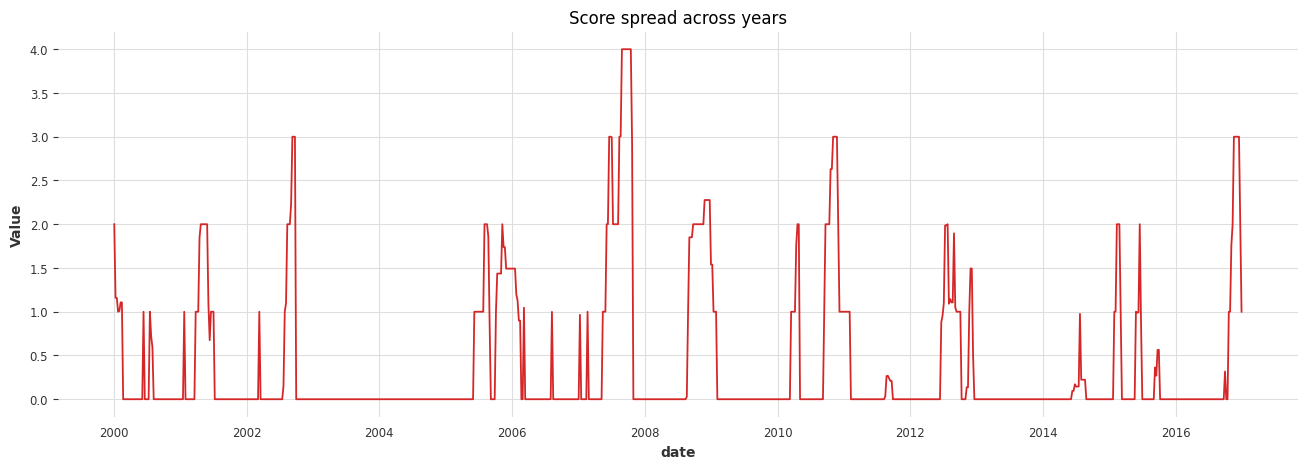

In [121]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data, x=data.ds, y=data.y, title='Score spread across years')  

## 8.2 Plot the 'score' and 'score_change'

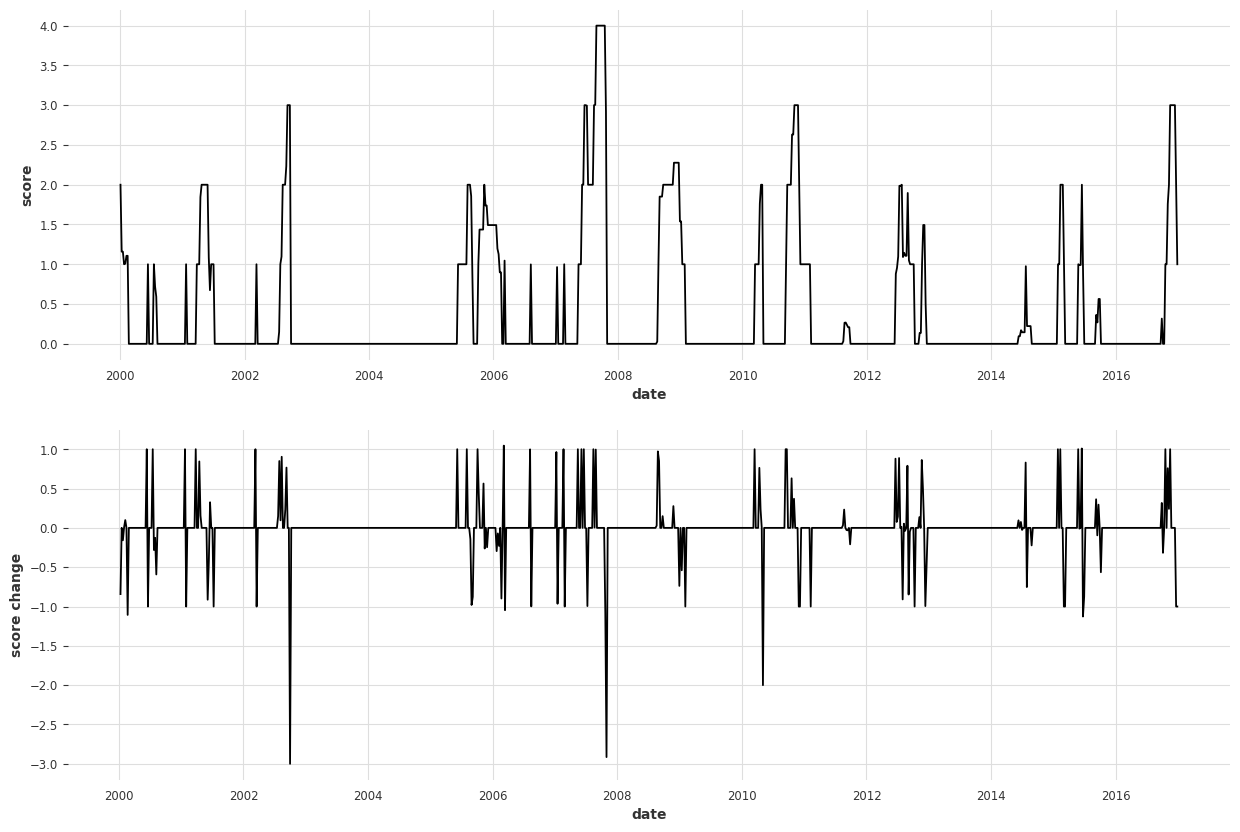

In [122]:
# Plot the daily score as well as the daily change.
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.plot(data["ds"], data["y"])
plt.xlabel("date")
plt.ylabel("score")
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(data["ds"], data["score_change"])
plt.xlabel("date")
plt.ylabel("score change")
plt.grid(True)
plt.show()

## 8.3 Score by Year

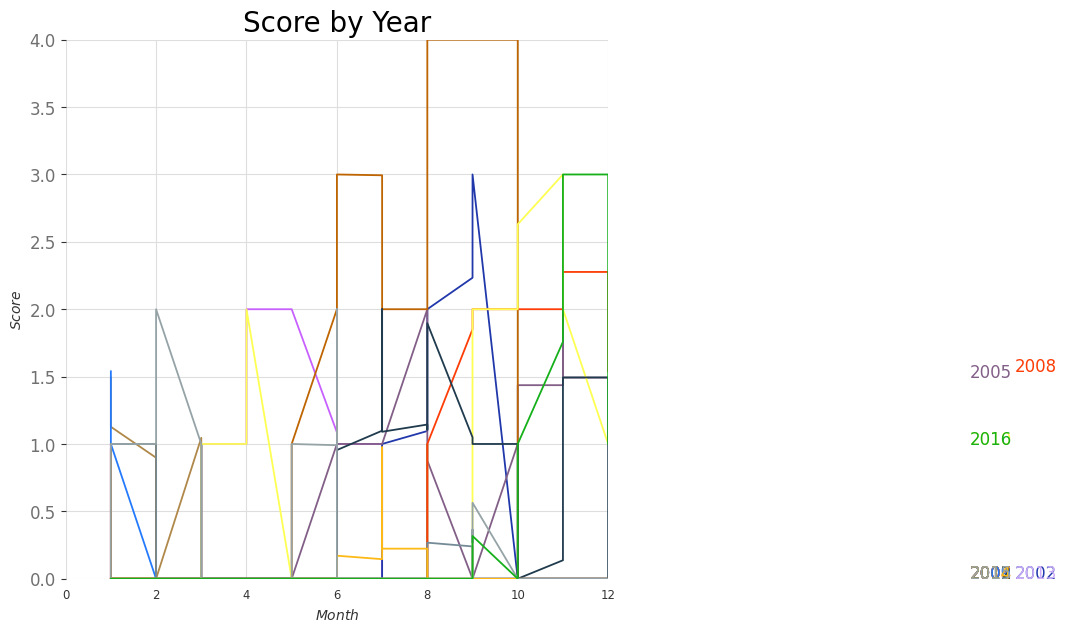

In [123]:
# Prepare data
#data['year'] = [d.year for d in data.date]
#data['month1'] = [d.strftime('%b') for d in data.index]
years = data['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(7,7), dpi= 100)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'y', data=data.loc[data.year==y, :], color=mycolors[i], label=y)
        plt.text(data.loc[data.year==y, :].shape[0]-32, data.loc[data.year==y, 'y'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(0, 12), ylim=(0, 4), ylabel='$Score$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Score by Year", fontsize=20)
plt.show()

## 8.4 Year-wise and Month-wise Box Plot

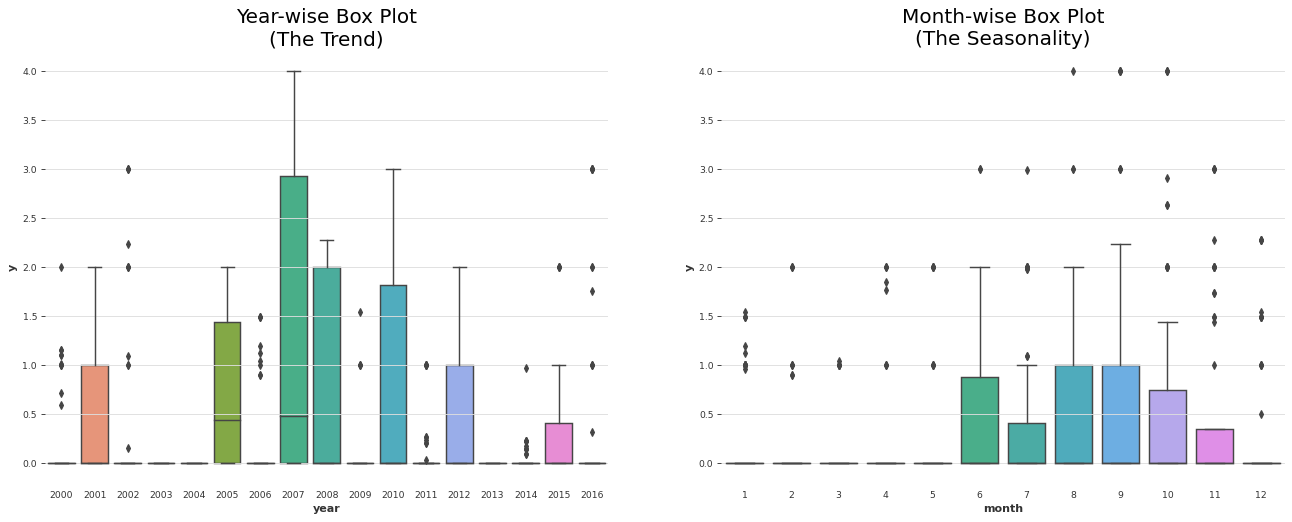

In [124]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='y', data=data, ax=axes[0])
sns.boxplot(x='month', y='y', data=data.loc[~data.year.isin([2000, 2016]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## 8.5 Additive decomposition of Score

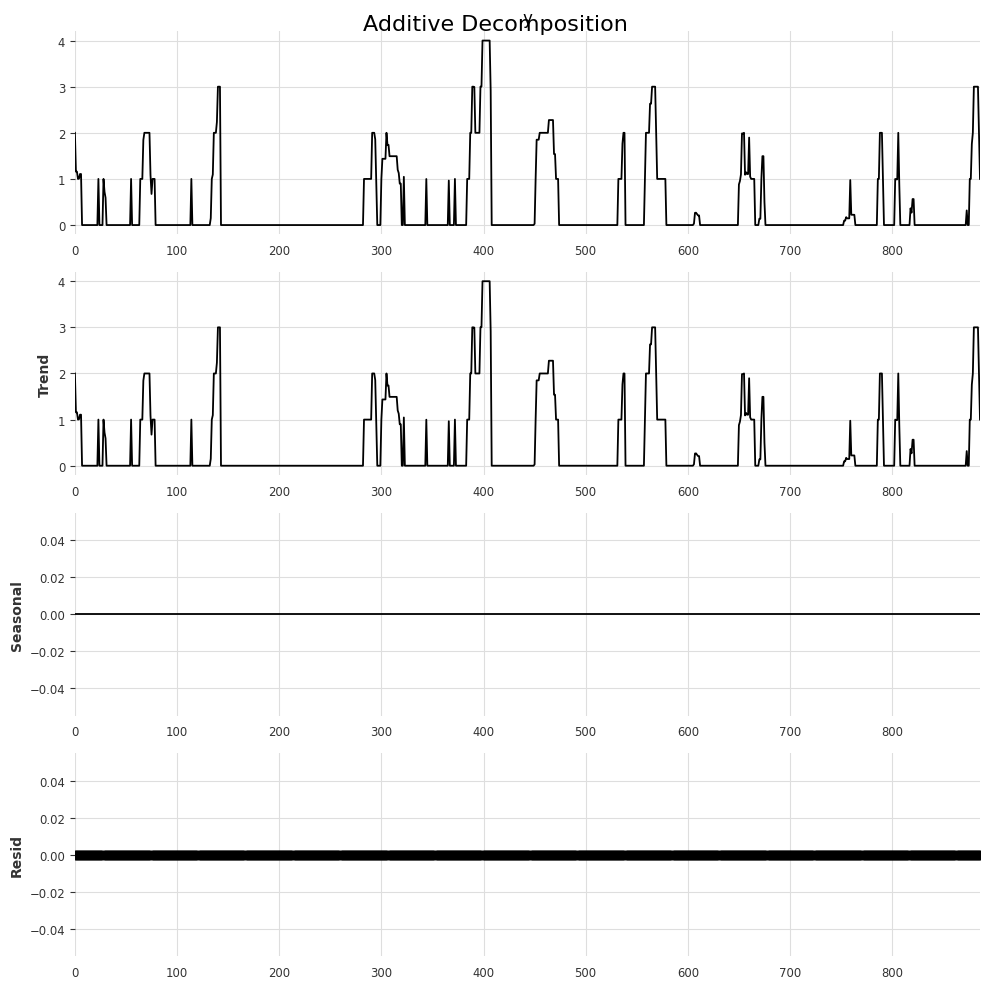

In [125]:
# Multiplicative Decomposition  - can't calculate due to zero values
#result_mul = seasonal_decompose(data['score'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(data['y'], model='additive', extrapolate_trend='freq', period = 1)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=16)
result_add.plot().suptitle('Additive Decomposition', fontsize=16)
plt.show()

## 8.6 Test for stationarity

Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time.

That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time. Autocorrelation of the series is nothing but the correlation of the series with its previous values. Understand that it is possible to make nearly any time series stationary by applying a suitable transformation. Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary.

The stationarity of a series can be established by looking at the plot of the series like we did earlier.

Another method is to split the series into 2 or more contiguous parts and computing the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

Nevertheless, you need a method to quantitatively determine if a given series is stationary or not. This can be done using statistical tests called ‘Unit Root Tests’. There are multiple variations of this, where the tests check if a time series is non-stationary and possess a unit root.

There are multiple implementations of Unit Root tests like:

- Augmented Dickey Fuller test (ADH Test)
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
- Philips Perron test (PP Test)

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. The null hypothesis of the ADF test is that the time series data is non-stationary, while the alternative hypothesis is that the time series data is stationary. So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test. The below code implements these two tests using statsmodels package in python. The null hypothesis of the KPSS test is that the time series data is stationary, while the alternative hypothesis is that the time series data is non-stationary. If the p-value is less than a pre-determined significance level (such as 0.05 or 0.01), then we reject the null hypothesis and conclude that the time series data is non-stationary. Conversely, if the p-value is greater than the significance level, we fail to reject the null hypothesis and conclude that the time series data is stationary.

In [126]:
# Perform ADF test
adfullerresult = adfuller(data['y'])

# Print test results
print('ADF Statistic: %f' % adfullerresult[0])
print('p-value: %f' % adfullerresult[1])
print('Critical Values:')
for key, value in adfullerresult[4].items():
    print('\t%s: %.3f' % (key, value))
    
# KPSS Test
kpssresult = kpss(data.y.values, regression='c')
print('\nKPSS Statistic: %f' % kpssresult[0])
print('p-value: %f' % kpssresult[1])
for key, value in kpssresult[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.989497
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569

KPSS Statistic: 0.102846
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


# 9.0 Timeseries forecasting with PanelARIMA (uses Panel Data)

In [127]:
def panel_arima_forecast(data, p, d, q, P, D, Q, s, forecast_periods, group_name):
    """
    Performs timeseries forecasting with PanelARIMA and returns predictions and accuracy metrics.

    Parameters:
    data (pandas.DataFrame): DataFrame with date column (ds) and response column (y).
    p (int): Order of the AR component.
    d (int): Order of differencing.
    q (int): Order of the MA component.
    P (int): Order of the seasonal AR component.
    D (int): Order of seasonal differencing.
    Q (int): Order of the seasonal MA component.
    s (int): Seasonal period length.
    forecast_periods (int): Number of periods to forecast.

    Returns:
    - y_true (numpy.ndarray): True values of the response variable in the test set.
    - y_pred (numpy.ndarray): Predicted values of the response variable in the test set.
    - mse (float): Mean squared error between y_true and y_pred.
    - mae (float): Mean absolute error between y_true and y_pred.
    - rmse (float): Root mean squared error between y_true and y_pred.
    - mape (float): Mean absolute percentage error between y_true and y_pred.
    - smape (float): Symmetric mean absolute percentage error between y_true and y_pred.
    - r_squared (float): Coefficient of determination (R-squared) between y_true and y_pred.
    - forecast_acc (float): Forecast accuracy between y_true and y_pred.
    """
    
    stationarity_test_boolean = False

    # Split data into train and test sets
    train_data = data.iloc[:-forecast_periods]
    #print("\ntrain_data shape:",train_data.shape)
    #print("\ntrain_data type:",type(train_data))
    #print("\ntrain_data:",train_data)
    
    test_data = data.iloc[-forecast_periods:]
    #print("\ntest_data shape:",test_data.shape)
    #print("\ntest_data type:",type(test_data))
    #print("\ntest_data:",test_data)

    # Group data by panel identifier (if applicable)
    if group_name in data.columns:
        panel_train_data = train_data.groupby(group_name)
        panel_test_data = test_data.groupby(group_name)
    else:
        panel_train_data = [(None, train_data)]
        panel_test_data = [(None, test_data)]
    #print("\npanel_train_data type:",type(panel_train_data))
    #print("\npanel_train_data:",panel_train_data)
    #print("\npanel_test_data type:",type(panel_test_data))
    #print("\npanel_test_data:",panel_test_data)

    # Fit PanelARIMA model and generate forecasts for each panel
    forecasts = []
    for group, group_data in panel_train_data:
        
        #print("\nGroup name:",group)
        #print("\nGroup data:",group_data)
        
        if adfullerresult[1]<=0.05:
            print("Data is stationary")
            #Define the model
            model = sm.tsa.statespace.SARIMAX(group_data['y'], order=(p, d, q), seasonal_order=(P, D, Q, s))
            stationarity_test_boolean = True
        else:
            print("Data is not stationary, hence going ahead with 'Differencing' strategy")
            #Define the model
            model = sm.tsa.statespace.SARIMAX(group_data['score_change'], order=(p, d, q), seasonal_order=(P, D, Q, s))

        #Fit the model
        results = model.fit(disp=False)
        #print("\nresults type:",type(results))
        #print("\nresults:",results)

        #Get forecast
        panel_forecast = results.get_forecast(steps=forecast_periods, freq='W-TUE')
        #print("\npanel_forecast type:",type(panel_forecast))
        #print("\npanel_forecast:",panel_forecast)

        panel_forecast_df = panel_forecast.summary_frame()
        panel_forecast_df['group'] = group
        #print("\npanel_forecast type:",type(panel_forecast_df))
        #print("\npanel_forecast:\n",panel_forecast_df)

        forecasts.append(panel_forecast_df)

        # save the model as a .sav file
        filename = f'{group}_panel_arima_.sav'
        pickle.dump(model, open(filename, 'wb'))
        
        # save the model as a .pkl file
        filename = f'{group}_panel_arima_.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(model, f)

    # Combine forecasts into a single DataFrame
    forecasts_df = pd.concat(forecasts, axis=0)
    forecasts_df.reset_index(inplace=True)
    #print("\nforecasts_df shape:",forecasts_df.shape)
    #print("\nforecasts_df type:",type(forecasts_df))
    #print("\nforecasts_df:",forecasts_df)

    # Merge forecasted values with test set
    test_data.reset_index(inplace=True)
    #print("\ntest_data shape:",test_data.shape)
    #print("\ntest_data type:",type(test_data))
    #print("\ntest_data:",test_data)
    forecasted_data = pd.merge(test_data, forecasts_df[['index', 'mean', 'mean_ci_lower', 'mean_ci_upper']], how='inner', on='index')
    
    if stationarity_test_boolean == False:
        #print("update data with real score")
        forecasted_data['mean'] = forecasted_data['mean'] + forecasted_data['y']
    #print("\nforecasts_data shape:",forecasted_data.shape)
    #print("\nforecasts_data type:",type(forecasted_data))
    #print("\nforecasts_data:\n",forecasted_data)

    # Calculate accuracy metrics (e.g., mean absolute error, root mean squared error)
    y_true = forecasted_data['y'].values
    print("\ny_true:", y_true)

    y_pred = forecasted_data['mean'].values
    print("\ny_pred:", y_pred)
    
    y_pred_lower = forecasted_data['mean_ci_lower'].values
    print("\ny_pred_lower:", y_pred_lower)
    
    y_pred_upper = forecasted_data['mean_ci_upper'].values
    print("\ny_pred_upper:", y_pred_upper)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_true, y_pred)
    print("\nMean Squared Error:", mse)
    
    # Calculate the mean absolute error
    mae = np.mean(np.abs(y_true - y_pred))
    print("\nMean Absolute Error:", mae)
    
    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    print("\nRoot Mean Squared Error:", rmse)
    
    # Calculate the mean absolute percentage error
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_pred, epsilon))) * 100
    print("\nMean Absolute Percentage Error:", mape, "%")
    
    # Calculate the symmetric mean absolute percentage error
    smape = np.mean(np.abs((y_true - y_pred) / ((y_true + y_pred)/2))) * 100
    print("\nSymmetric Mean Absolute Percentage Error:", smape, "%")
    
    # Calculate the coefficient of determination (R-squared)
    r_squared = r2_score(y_true, y_pred)
    #r_squared = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_pred - np.mean(y_pred))**2)
    print("\nR-squared:", r_squared)
    
    #calculate accuracy
    forecasted_data['abs_error'] = abs(forecasted_data['y']-forecasted_data['mean']) 
    #print(forecasted_data['y'], ' ', forecasted_data['mean'])
    #forecasted_data.head()
    forecasted_data['daily_FA'] = 1-(forecasted_data['abs_error']/np.maximum(forecasted_data['y'], epsilon))
    #forecasted_data.head(50)
    total_y = sum(np.maximum(forecasted_data['y'], epsilon))
    #print(total_y)
    total_error = sum(forecasted_data['abs_error'])
    #print(total_error)
    if total_y != 0:
        forecast_acc = 1-(total_error/total_y)
    else:
        forecast_acc = "can't calculate due to '0' in denominator"
    print ("\nForecast accuracy:", forecast_acc)
    
    # create a dictionary with column names as keys and variable values as values
    new_row = {'model_name': "Panel ARIMA", 'y_true': y_true, 'y_pred': y_pred, 'mse': mse, 'mae': mae, 'rmse': rmse, 'mape': mape, 'smape': smape, 'r_squared': r_squared, 'forecast_acc': forecast_acc}

    return y_true, y_pred, y_pred_lower, y_pred_upper, mse, mae, rmse, mape, smape, r_squared, forecast_acc, new_row

**orderiterable or iterable of iterables, optional**

The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).

**seasonal_orderiterable, optional**

The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. D must be an integer indicating the integration order of the process, while P and Q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect.

In [128]:
#panel_arima_forecast(data, p, d, q, P, D, Q, s, forecast_periods)
y_true1, y_pred1, y_pred_lower1, y_pred_upper1, mse1, mae1, rmse1, mape1, smape1, r_squared1, forecast_acc1, new_row1 = panel_arima_forecast(data, 1, 0, 0, 0, 0, 0, 12, no_of_periods_of_prediction, "fips")

# append the dictionary as a new row to the dataframe
regResult = regResult.append(new_row1, ignore_index=True)

Data is stationary

y_true: [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.3169 0.     0.     1.     1.     1.7584 2.     3.
 3.     3.     3.     3.     2.     1.    ]

y_pred: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

y_pred_lower: [-0.61769255 -0.84414232 -0.99989184 -1.11757249 -1.21043948 -1.28558839
 -1.34739702 -1.39881198 -1.44193566 -1.47833147 -1.50919796 -1.53547547
 -1.5579151  -1.57712534 -1.59360477 -1.60776567 -1.61995155 -1.63045037
 -1.63950481 -1.64732023 -1.65407106 -1.65990591 -1.66495174 -1.6693172
 -1.67309549 -1.67636669 -1.67919965 -1.6816537  -1.68377996 -1.68562256
 -1.68721959 -1.68860397 -1.68980415 -1.69084476 -1.69174708 -1.69252955
 -1.69320815 -1.69379668 -1.69430713 -1.69474988 -1.695133

# 10.0 Timeseries forecasting with HMMLearn (doesn't uses Panel Data)

In [129]:
def HMM_Learn_forecast(data, forecast_periods, group_name):

    stationarity_test_boolean = False
    
    data_copy = data.copy(deep=True)
    data_copy.set_index('ds', inplace=True)
    
    # Split data into train and test sets
    train_data = data_copy.iloc[:-forecast_periods]
    train_data = train_data[['y','fips','score_change']]
    # Reset the index of the DataFrame
    train_data.reset_index(inplace=True)
    #print("\ntrain_data shape:",train_data.shape)
    #print("\ntrain_data type:",type(train_data))
    #print("\ntrain_data:",train_data)
    
    test_data = data_copy.iloc[-forecast_periods:]
    test_data = test_data[['y','fips','score_change']]
    # Reset the index of the DataFrame
    test_data.reset_index(inplace=True)
    #print("\ntest_data shape:",test_data.shape)
    #print("\ntest_data type:",type(test_data))
    #print("\ntest_data:",test_data)

    # Group data by panel identifier (if applicable)
    if group_name in data.columns:
        panel_train_data = train_data.groupby(group_name)
        panel_test_data = test_data.groupby(group_name)
    else:
        panel_train_data = [(None, train_data)]
        panel_test_data = [(None, test_data)]
    #print("\npanel_train_data type:",type(panel_train_data))
    #print("\npanel_train_data:",panel_train_data)
    #print("\npanel_test_data type:",type(panel_test_data))
    #print("\npanel_test_data:",panel_test_data)

    # Fit HMMLearn model and generate forecasts for each panel
    forecasts = []
    for group, group_data in panel_train_data:
        #print("\nGroup name:",group)
        #print("\nGroup data:",group_data)
        
        # Define the model using Gaussian HMM
        model = GaussianHMM(n_components=5, covariance_type="diag", n_iter=1000)

        if adfullerresult[1]<=0.05:
            print("Data is stationary")
            #Fit the model
            y_train_data = group_data['y'].values
            y_train_data = y_train_data.reshape(-1, 1)
            #print(y_train_data)
            results = model.fit(y_train_data)
            
            stationarity_test_boolean = True
        else:
            print("Data is not stationary, hence going ahead with 'Differencing' strategy")
            #Fit the model
            y_train_data = group_data['score_change'].values
            y_train_data = y_train_data.reshape(-1, 1)
            #print(y_train_data)
            #print(type(y_train_data))
            # Remove the first nan element
            y_train_data = y_train_data[1:]
            #print(y_train_data)
            results = model.fit(y_train_data)

        #print("\nresults type:",type(results))
        #print("\nresults:",results)

        #Get forecast
        # Generate a sequence of observations using the trained model
        predictions, _ = model.sample(n_samples=len(test_data))
        #print(predictions.shape)
        print(type(predictions))
        #print(predictions)

        # Generate lower-bound values
        # Get the log-likelihood of the trained model
        #log_likelihood = model.score(test_data)
        #print("Log-likelihood lower-bound:", log_likelihood)

        # Get the upper bound of the likelihood function
        # Get the convergence monitor object
        #monitor = model.monitor_
        #monitor_history = monitor.history
        # Print the final log-likelihood and the number of iterations
        #print("Log-likelihood upper-bound:", monitor_history[-1])
        #print("Number of iterations:", monitor.iter)
        
        panel_forecast_df = pd.DataFrame(predictions, columns=['Predictions'])
        panel_forecast_df['group'] = group
        forecasts.append(panel_forecast_df)
        
        # save the model as a .sav file
        filename = f'{group}_hmm_learn_.sav'
        pickle.dump(model, open(filename, 'wb'))
        
        # save the model as a .pkl file
        filename = f'{group}_hmm_learn_.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(model, f)

    # Combine forecasts into a single DataFrame
    forecasts_df = pd.concat(forecasts, axis=0)
    forecasts_df.reset_index(inplace=True)
    #print("\nforecasts_df shape:",forecasts_df.shape)
    #print("\nforecasts_df type:",type(forecasts_df))
    #print("\nforecasts_df:",forecasts_df)

    # Merge forecasted values with test set
    test_data.reset_index(inplace=True)
    #print("\ntest_data shape:",test_data.shape)
    #print("\ntest_data type:",type(test_data))
    #print("\ntest_data:",test_data)
    forecasted_data = pd.merge(test_data, forecasts_df, how='inner', on='index')
    
    if stationarity_test_boolean == False:
        #print("update data with real score")
        forecasted_data['Predictions'] = forecasted_data['Predictions'] + forecasted_data['y']
    #print("\nforecasts_data shape:",forecasted_data.shape)
    #print("\nforecasts_data type:",type(forecasted_data))
    #print("\nforecasts_data:",forecasted_data)
    # set the 'ds' column as the index
    forecasted_data.set_index('ds', inplace=True)    
    
    #Predict with test_data
    #Z = model.predict(test_data)

    # Predict the hidden states corresponding to observed X.
    #states = pd.unique(Z)
    #print("Unique states:")
    #print(states)
    
    print("\nStart probabilities:")
    start_probabilities = model.startprob_
    print(start_probabilities)

    print("\nTransition matrix:")
    transition_matrix = model.transmat_
    print(transition_matrix)

    print("\nGaussian distribution means:")
    gaussian_distribution_means = model.means_
    print(gaussian_distribution_means)

    print("\nGaussian distribution covariances:")
    gaussian_distribution_covariances = model.covars_
    print(gaussian_distribution_covariances)

    # Print HMM stats
    print('\nMeans and variances:')
    for i in range(model.n_components):
        print('\nHidden state', i+1)
        print('Mean =', round(model.means_[i][0], 2))
        print('Variance =', round(np.diag(model.covars_[i])[0], 2))
        
    # Calculate accuracy metrics (e.g., mean absolute error, root mean squared error)
    y_true = forecasted_data['y'].values
    print("\ny_true:", y_true)

    y_pred = forecasted_data['Predictions'].values
    print("\ny_pred:", y_pred)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_true, y_pred)
    print("\nMean Squared Error:", mse)
    
    # Calculate the mean absolute error
    mae = np.mean(np.abs(y_true - y_pred))
    print("\nMean Absolute Error:", mae)
    
    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    print("\nRoot Mean Squared Error:", rmse)
    
    # Calculate the mean absolute percentage error
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_pred, epsilon))) * 100
    print("\nMean Absolute Percentage Error:", mape, "%")
    
    # Calculate the symmetric mean absolute percentage error
    smape = np.mean(np.abs((y_true - y_pred) / ((y_true + y_pred)/2))) * 100
    print("\nSymmetric Mean Absolute Percentage Error:", smape, "%")
    
    # Calculate the coefficient of determination (R-squared)
    r_squared = r2_score(y_true, y_pred)
    #r_squared = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_pred - np.mean(y_pred))**2)
    print("\nR-squared:", r_squared)
    
    #calculate accuracy
    forecasted_data['abs_error'] = abs(forecasted_data['y']-forecasted_data['Predictions']) 
    #print(forecasted_data['y'], ' ', forecasted_data['mean'])
    #forecasted_data.head()
    forecasted_data['daily_FA'] = 1-(forecasted_data['abs_error']/np.maximum(forecasted_data['y'], epsilon))
    #forecasted_data.head(50)
    total_y = sum(np.maximum(forecasted_data['y'], epsilon))
    #print(total_y)
    total_error = sum(forecasted_data['abs_error'])
    #print(total_error)
    if total_y != 0:
        forecast_acc = 1-(total_error/total_y)
    else:
        forecast_acc = "can't calculate due to '0' in denominator"
    print ("\nForecast accuracy:", forecast_acc)
    
    # create a dictionary with column names as keys and variable values as values
    new_row = {'model_name': "HMM Learn", 'y_true': y_true, 'y_pred': y_pred, 'mse': mse, 'mae': mae, 'rmse': rmse, 'mape': mape, 'smape': smape, 'r_squared': r_squared, 'forecast_acc': forecast_acc}

    return start_probabilities, transition_matrix, gaussian_distribution_means, gaussian_distribution_covariances, y_true, y_pred, mse, mae, rmse, mape, smape, r_squared, forecast_acc, new_row

In [130]:
#HMM_Learn_forecast()
start_probabilities2, transition_matrix2, gaussian_distribution_means2, gaussian_distribution_covariances2, y_true2, y_pred2, mse2, mae2, rmse2, mape2, smape2, r_squared2, forecast_acc2, new_row2 = HMM_Learn_forecast(data, no_of_periods_of_prediction, "fips")

# append the dictionary as a new row to the dataframe
regResult = regResult.append(new_row2, ignore_index=True)

Data is stationary
<class 'numpy.ndarray'>

Start probabilities:
[0.00000000e+00 1.00000000e+00 1.04245650e-23 0.00000000e+00
 2.34681731e-33]

Transition matrix:
[[9.63775637e-01 0.00000000e+00 1.21938656e-02 2.40304975e-02
  1.66141538e-64]
 [2.26636761e-02 6.85042937e-01 1.32505052e-01 4.44683607e-02
  1.15319975e-01]
 [1.24389395e-01 7.51235667e-02 7.34258781e-01 6.62282579e-02
  2.43019273e-20]
 [2.06611612e-01 8.95152017e-02 1.08939683e-01 5.94933503e-01
  1.89361179e-11]
 [6.92515015e-02 6.90350854e-02 3.56499874e-02 2.50665635e-11
  8.26063426e-01]]

Gaussian distribution means:
[[4.22654942e-12]
 [1.99937935e+00]
 [9.51598457e-01]
 [9.99721366e-01]
 [3.09565877e+00]]

Gaussian distribution covariances:
[[[1.57240224e-05]]

 [[2.37250690e-04]]

 [[3.42415608e-01]]

 [[2.36231879e-04]]

 [[3.92266965e-01]]]

Means and variances:

Hidden state 1
Mean = 0.0
Variance = 0.0

Hidden state 2
Mean = 2.0
Variance = 0.0

Hidden state 3
Mean = 0.95
Variance = 0.34

Hidden state 4
Mean = 1

# 11.0 Prophet from Facebook

In [131]:
def Prophet_from_FB_forecast(data, forecast_periods, group_name):
    """
    The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.
    
    """
    stationarity_test_boolean = False
    
    data_copy = data.copy(deep=True)
    #data_copy.set_index('ds', inplace=True)
    
    #Aggregate to the FIPS level
    data_copy = data_copy.groupby(['ds','fips'],as_index=False).sum()
    data_copy
    
    # Split data into train and test sets
    train_data = data_copy.iloc[:-forecast_periods]
    train_data = train_data[['ds','y','fips','score_change']]
    # Reset the index of the DataFrame
    train_data.reset_index(inplace=True)
    #print("\ntrain_data shape:",train_data.shape)
    #print("\ntrain_data type:",type(train_data))
    #print("\ntrain_data:",train_data)
    
    test_data = data_copy.iloc[-forecast_periods:]
    test_data = test_data[['y','fips','score_change']]
    # Reset the index of the DataFrame
    test_data.reset_index(inplace=True)
    #print("\ntest_data shape:",test_data.shape)
    #print("\ntest_data type:",type(test_data))
    #print("\ntest_data:",test_data)

    # Group data by panel identifier (if applicable)
    if group_name in data.columns:
        panel_train_data = train_data.groupby(group_name)
        panel_test_data = test_data.groupby(group_name)
    else:
        panel_train_data = [(None, train_data)]
        panel_test_data = [(None, test_data)]
    #print("\npanel_train_data type:",type(panel_train_data))
    #print("\npanel_train_data:",panel_train_data)
    #print("\npanel_test_data type:",type(panel_test_data))
    #print("\npanel_test_data:",panel_test_data)

    # Fit HMMLearn model and generate forecasts for each panel
    forecasts = []
    for group, group_data in panel_train_data:
        #print("\nGroup name:",group)
        #print("\nGroup data:\n",group_data)
        
        #Define the model
        model = Prophet()

        if adfullerresult[1]<=0.05:
            print("Data is stationary")
            #Fit the model
            y_train_data = group_data['y'].values
            y_train_data = y_train_data.reshape(-1, 1)
            #print(y_train_data)
            #print(type(y_train_data))
            results = model.fit(group_data)
            #print("\nresults type:",type(results))
            #print("\nresults:",results)
            
            stationarity_test_boolean = True
        else:
            print("Data is not stationary, hence going ahead with 'Differencing' strategy")
            #Fit the model
            y_train_data = group_data['score_change'].values
            y_train_data = y_train_data.reshape(-1, 1)
            #print(y_train_data)
            #print(type(y_train_data))
            # Remove the first nan element
            y_train_data = y_train_data[1:]
            #print(y_train_data)
            group_data = group_data.rename(columns={'y': 'y-real'})
            group_data = group_data.rename(columns={'score_change': 'y'})
            #print("\nGroup data:\n",group_data)
            results = model.fit(group_data)
            
        #Get forecast
        # Generate a sequence of observations using the trained model
        future = model.make_future_dataframe(periods=no_of_periods_of_prediction, freq='W-TUE')
        forecast = model.predict(future)
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
        #print(predictions.shape)
        #print(type(predictions))
        #print(predictions)s
        
        fig1 = model.plot(forecast)
        
        fig2 = model.plot_components(forecast)
        
        #plot_plotly(model, forecast)
        
        #plot_components_plotly(model, forecast)
        
        panel_forecast_df = pd.DataFrame(forecast, columns=['ds', 'yhat', 'yhat_lower', 'yhat_upper'])
        panel_forecast_df['group'] = group
        forecasts.append(panel_forecast_df)
        
        filename_json = str(group) + "_propher_learn.json"
        with open(filename_json, 'w') as fout:
            fout.write(model_to_json(model))  # Save model

        with open(filename_json, 'r') as fin:
            model = model_from_json(fin.read())  # Load model
        
        # save the model as a .sav file
        filename = f'{group}_hmm_learn_.sav'
        pickle.dump(model, open(filename, 'wb'))
        
        # save the model as a .pkl file
        filename = f'{group}_hmm_learn_.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(model, f)

    # Combine forecasts into a single DataFrame
    forecasts_df = pd.concat(forecasts, axis=0)
    forecasts_df.reset_index(inplace=True)
    #print("\nforecasts_df shape:",forecasts_df.shape)
    #print("\nforecasts_df type:",type(forecasts_df))
    #print("\nforecasts_df:",forecasts_df)

    # Merge forecasted values with test set
    test_data.reset_index(inplace=True)
    #print("\ntest_data shape:",test_data.shape)
    #print("\ntest_data type:",type(test_data))
    #print("\ntest_data:",test_data)
    forecasted_data = pd.merge(test_data, forecasts_df, how='inner', on='index')

    if stationarity_test_boolean == False:
        #print("update data with real score")
        forecasted_data['yhat'] = forecasted_data['yhat'] + forecasted_data['y']
    #print("\nforecasts_data shape:",forecasted_data.shape)
    #print("\nforecasts_data type:",type(forecasted_data))
    #print("\nforecasts_data:\n",forecasted_data)
    # set the 'ds' column as the index
    forecasted_data.set_index('ds', inplace=True)    
    
    # Calculate accuracy metrics (e.g., mean absolute error, root mean squared error)
    y_true = forecasted_data['y'].values
    print("\ny_true:", y_true)

    y_pred = forecasted_data['yhat'].values
    print("\ny_pred:", y_pred)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_true, y_pred)
    print("\nMean Squared Error:", mse)
    
    # Calculate the mean absolute error
    mae = np.mean(np.abs(y_true - y_pred))
    print("\nMean Absolute Error:", mae)
    
    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    print("\nRoot Mean Squared Error:", rmse)
    
    # Calculate the mean absolute percentage error
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_pred, epsilon))) * 100
    print("\nMean Absolute Percentage Error:", mape, "%")
    
    # Calculate the symmetric mean absolute percentage error
    smape = np.mean(np.abs((y_true - y_pred) / ((y_true + y_pred)/2))) * 100
    print("\nSymmetric Mean Absolute Percentage Error:", smape, "%")
    
    # Calculate the coefficient of determination (R-squared)
    r_squared = r2_score(y_true, y_pred)
    #r_squared = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_pred - np.mean(y_pred))**2)
    print("\nR-squared:", r_squared)
    
    #calculate accuracy
    forecasted_data['abs_error'] = abs(forecasted_data['y']-forecasted_data['yhat']) 
    #print(forecasted_data['y'], ' ', forecasted_data['mean'])
    #forecasted_data.head()
    forecasted_data['daily_FA'] = 1-(forecasted_data['abs_error']/np.maximum(forecasted_data['y'], epsilon))
    #forecasted_data.head(50)
    total_y = sum(np.maximum(forecasted_data['y'], epsilon))
    #print(total_y)
    total_error = sum(forecasted_data['abs_error'])
    #print(total_error)
    if total_y != 0:
        forecast_acc = 1-(total_error/total_y)
    else:
        forecast_acc = "can't calculate due to '0' in denominator"
    print ("\nForecast accuracy:", forecast_acc)
    
    # create a dictionary with column names as keys and variable values as values
    new_row = {'model_name': "Prophet", 'y_true': y_true, 'y_pred': y_pred, 'mse': mse, 'mae': mae, 'rmse': rmse, 'mape': mape, 'smape': smape, 'r_squared': r_squared, 'forecast_acc': forecast_acc}

    return y_true, y_pred, mse, mae, rmse, mape, smape, r_squared, forecast_acc, model, forecast, new_row

Data is stationary


05:33:07 - cmdstanpy - INFO - Chain [1] start processing
05:33:07 - cmdstanpy - INFO - Chain [1] done processing



y_true: [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.3169 0.     0.     1.     1.     1.7584 2.     3.
 3.     3.     3.     3.     2.     1.    ]

y_pred: [-0.05420266 -0.11362492 -0.16558965 -0.19386314 -0.20037833 -0.19351364
 -0.17331901 -0.13580676 -0.08974787 -0.05985497 -0.06635745 -0.10207387
 -0.13401069 -0.12954742 -0.08082119 -0.00588534  0.06794945  0.11879217
  0.13467761  0.11568266  0.07831454  0.05264806  0.0639036   0.11097227
  0.16657819  0.20446146  0.22647775  0.2581488   0.31574762  0.38252525
  0.42274307  0.41774419  0.38171778  0.3397758   0.29764446  0.24226621
  0.17208221  0.11509253  0.10505738  0.13933351  0.17040523  0.14840974
  0.07203605 -0.00838531 -0.04046889 -0.01906211]

Mean Squared Error: 1.2183270094883307

Mean Absolute Error: 0.6173877185553647

Root Mean Squared Error: 1.

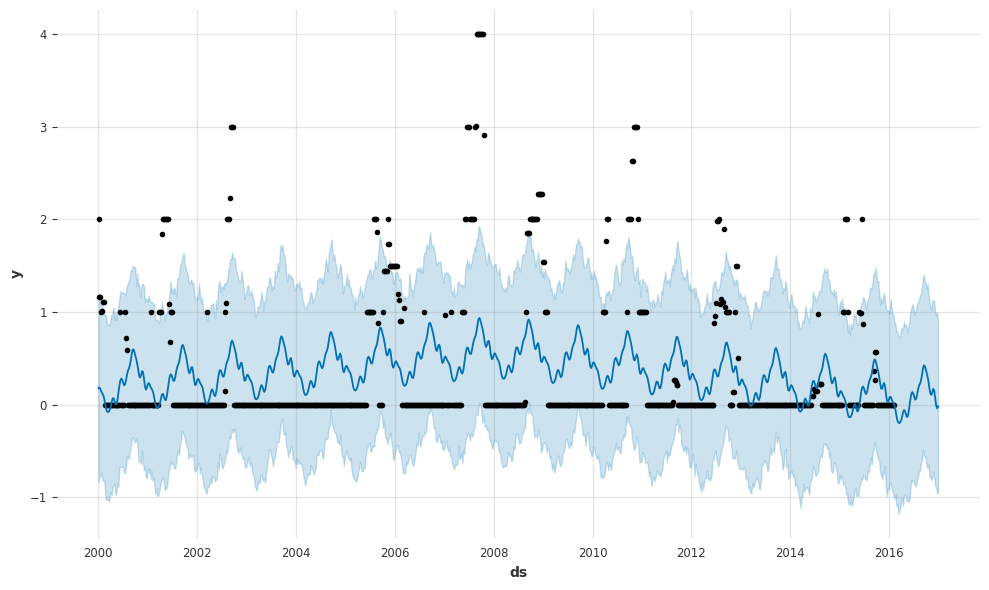

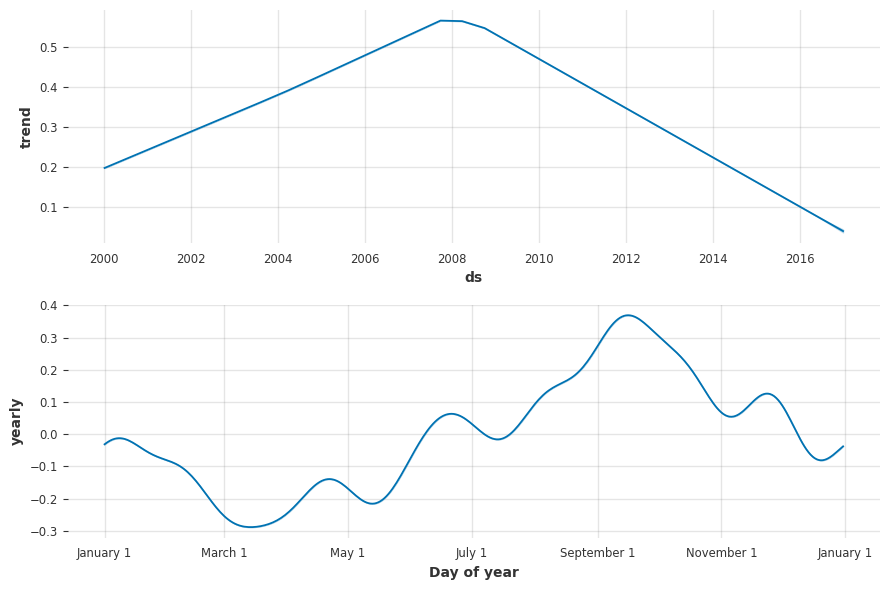

In [132]:
#Prophet_from_FB_forecast()
y_true4, y_pred4, mse4, mae4, rmse4, mape4, smape4, r_squared4, forecast_acc4, model4, forecast4, new_row4 = Prophet_from_FB_forecast(data, no_of_periods_of_prediction, "fips")

# append the dictionary as a new row to the dataframe
regResult = regResult.append(new_row4, ignore_index=True)

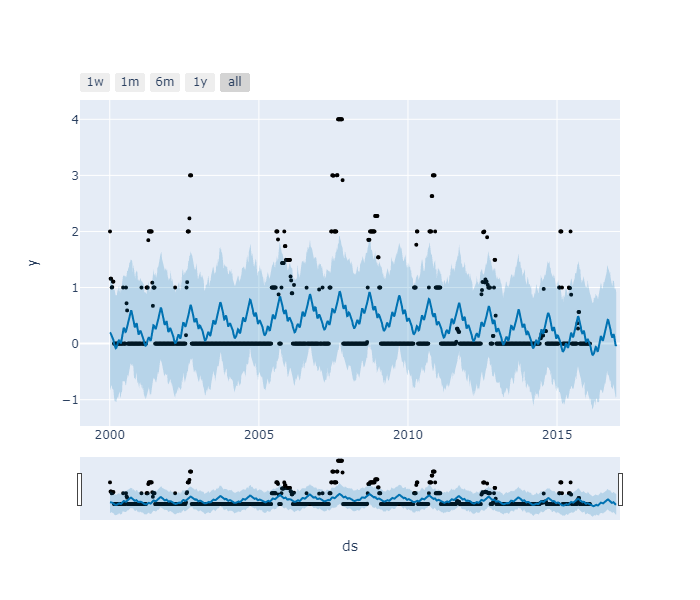

In [133]:
plot_plotly(model4, forecast4)

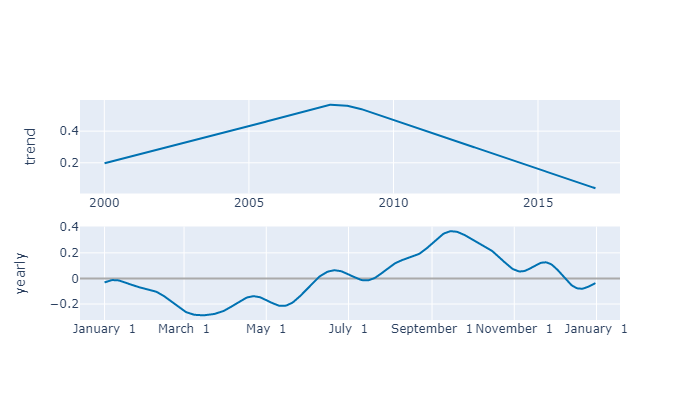

In [134]:
plot_components_plotly(model4, forecast4)

# 4.0 Comparision

In [135]:
print("\nChosen_FIPS:", Chosen_FIPS)


Chosen_FIPS: 21073


In [136]:
print("\nNo. of periods of prediction (each Tuesday of the other week):", no_of_periods_of_prediction)


No. of periods of prediction (each Tuesday of the other week): 46


In [137]:
print("\nTest for Stationarity")

# ADF Test
print('\nADF Statistic: %f' % adfullerresult[0])
print('ADF p-value: %f' % adfullerresult[1])
print('ADF Critical Values:')
for key, value in adfullerresult[4].items():
    print('\t%s: %.3f' % (key, value))
if adfullerresult[1] <= 0.05:
    print("Given that p-value is <=0.05, we reject the null hypothesis, and therefore the original presented data is stationary")
else:
    print("Given that p-value is >0.05, we accept the null hypothesis, and therefore the original presented data is not stationary")
    
# KPSS Test
print('\nKPSS Statistic: %f' % kpssresult[0])
print('KPSS p-value: %f' % kpssresult[1])
print('KPSS Critial Values:')
for key, value in kpssresult[3].items():
    print(f'   {key}, {value}')
if kpssresult[1] > 0.05:
    print("Given that p-value is <=0.05, we reject the null hypothesis, and therefore the original presented data is stationary")
else:
    print("Given that p-value is >0.05, we accept the null hypothesis, and therefore the original presented data is not stationary")


Test for Stationarity

ADF Statistic: -6.989497
ADF p-value: 0.000000
ADF Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Given that p-value is <=0.05, we reject the null hypothesis, and therefore the original presented data is stationary

KPSS Statistic: 0.102846
KPSS p-value: 0.100000
KPSS Critial Values:
   10%, 0.347
   5%, 0.463
   2.5%, 0.574
   1%, 0.739
Given that p-value is <=0.05, we reject the null hypothesis, and therefore the original presented data is stationary


In [138]:
regResult

,model_name,y_true,y_pred,mse,mae,rmse,mape,smape,r_squared,forecast_acc
0,Panel ARIMA,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.286791,0.523376,1.134368,NaN,NaN,-0.270442,0.000000
1,HMM Learn,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.9882535117230142, 2.614000310513706, 3.6154...",2.716029,1.107941,1.648038,inf,192.165963,-1.681522,-1.116912
2,Prophet,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05420265511906508, -0.11362492089017792, -...",1.218327,0.617388,1.103779,inf,191.020719,-0.202848,-0.179625
